# Multi Salmo microbetag networks analysis

## Building `microbetag`-annotated networks

### Data pre-process

Original files

- abundance data file: `salm_multi_filtered_30.tsv` (date: 27/05/2025 - email correspondence)
- taxonomy file: `salm_multio_abd_table_gc.tsv` (since the filtered_30 abundance data file has no classification column, we will use a previous version of the file to make sure we map the MAG ID to the correct taxonomy)
- metadata file: `sample_metadata_corrected.csv` (date: 20/6/25 - discord message ; yet metabolites not included)
- metabolites data: `original_mets_data_20250113.xlsx` (cannot track how I got this)

In the following chunk we bring the samples of the two files (columns) in the same order -- necessary for FlashWeave to build networks using metadata. 

In [2]:
abundance_file   = "salm_multi_filtered_30.tsv"
taxonomy_file    = "salm_multio_abd_table_gc.tsv"
metadata_file    = "sample_metadata_corrected.csv"
metabolites_file = "original_mets_data_20250113.xlsx"
template_config  = "config_v104.yml"

Load libraries and set root paths.

In [4]:
import os
import pandas as pd 
from pathlib import Path

root            = Path(os.getcwd())
input_data      = root / "data"
microbetag_data = root / "microbetag_input/"

Load abundance data

In [5]:
abd      = pd.read_csv(input_data / abundance_file, sep="\t", index_col=0)
abd.head(2)

,D300530,D300531,D300470,D300477,D300433,D300479,D300436,D300445,D300521,D300514,...,D300524,D300469,D300520,D300505,D300493,D300499,D300503,D300464,D300515,D300497
genome,,,,,,,,,,,,,,,,,,,,,
D300418:bin_000001,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D300418:bin_000013,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Load metadata file, mapping samples to their corresponding treatment and day.
In the following table we provide a short description of the treatments. 

|  Factor        |	TG1 | TG2 |	TG3 | TG4 | TG5 |
|:--------------:|:----:|:---:|:---:|:---:|:---:|
|salmonella	     | Yes	| Yes | Yes | Yes | No  |
|synbiotic_water | Yes	| Yes |	No  | No  |	No  |
|synbiotic_feed	 | Yes	| No  |	Yes | No  | No  |



In [6]:
metadata = pd.read_csv(input_data / metadata_file)
metadata.head(2)

,sample,batch,animal,tissue,treatment,day
0,D300530,S3B009,G000,Digesta,TG0,NaN
1,D300531,S3B009,G000,Digesta,TG0,NaN


In the metabolites file, you may see that a great number of metabolites were measured in the study, however we selected the most relevant that could affect the samples' communities, and we kept their values in the 'of-interest' sheet.

In [7]:
mets = pd.read_excel(input_data / metabolites_file, sheet_name="of-interest")

# For some reason there is an extra "M" in the end of the sample name 
mets.columns = [mets.columns[0]] + [col[:-1] for col in mets.columns[1:]]
mets.head(2)

,metabolite,G124,G030,G066,G044,G020,G113,G031,G050,G118,...,G007,G029,G032,G111,G017,G048,G026,G027,G104,G094
0,L-Tyrosine,1.154862e+06,1.070405e+06,7.233821e+05,1.439299e+06,632785.722057,1.157299e+06,6.014387e+05,1.961503e+06,1.125862e+06,...,6.721533e+05,462266.471921,471502.748026,1.546473e+06,328951.773787,656204.241988,2.938963e+06,4.103840e+06,1.906260e+06,1.910604e+06
1,L-Phenylalanine,1.233174e+06,1.647481e+06,1.049884e+06,2.071581e+06,681458.305129,2.325329e+06,1.862486e+06,2.386789e+06,1.744189e+06,...,2.686876e+06,727284.939809,955339.135261,2.574471e+06,525748.264667,753097.476399,2.199197e+07,2.619296e+07,1.816819e+06,2.377164e+06


We will now merge the metabolites' data with the rest of the metadata of each sample, so we use their combination to infer microbial co-occurrence networks with FlashWeave. 
To this end, we will use the `animal` column of the metadata, that has been used as the sample name for the metabolites' measurements. 

In [8]:
# Ensure 'metabolite' is set as index so rows are labeled by metabolite name
mets_indexed = mets.set_index('metabolite')

# Loop over each metabolite (each row in mets) and map values to metadata
for metabolite in mets_indexed.index:
    metadata[metabolite] = metadata['animal'].map(mets_indexed.loc[metabolite].to_dict())

print(metadata.shape)
metadata.head(2)


(114, 29)


,sample,batch,animal,tissue,treatment,day,L-Tyrosine,L-Phenylalanine,L-Tryptophan,L-Aspartic Acid,...,Thiamine,Adenine,Guanosine,L-Valine,L-Alanine,L-Asparagine,L-Isoleucine,L-Serine,Lactic acid,Sulfoacetic acid
0,D300530,S3B009,G000,Digesta,TG0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D300531,S3B009,G000,Digesta,TG0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
metadata[metadata["animal"] == "G003"]

,sample,batch,animal,tissue,treatment,day,L-Tyrosine,L-Phenylalanine,L-Tryptophan,L-Aspartic Acid,...,Thiamine,Adenine,Guanosine,L-Valine,L-Alanine,L-Asparagine,L-Isoleucine,L-Serine,Lactic acid,Sulfoacetic acid
93,D300477,S3B009,G003,Digesta,TG5,14.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


And to bring it a `microbetag`-friendly format, we will transpose the table.

In [10]:
metadata = metadata.T
metadata.columns = metadata.iloc[0]
metadata = metadata.drop(metadata.index[0])

# Make day an integer -- not a float
metadata.loc["day"] = metadata.loc["day"].astype('Int64')

metadata.head(2)

sample,D300530,D300531,D300529,D300480,D300517,D300428,D300509,D300516,D300510,D300483,...,D300524,D300469,D300520,D300505,D300493,D300499,D300503,D300464,D300515,D300497
batch,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,...,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009
animal,G000,G000,G085,G086,G087,G088,G089,G090,G091,G092,...,G115,G116,G118,G119,G120,G121,G122,G123,G124,G125


You may notice that `metadata` now, have 114 columns, thus 114 samples, as many as the abundance table, but the original `metabolites` dataframe had only 112; this is because no measurements were taken for the two blank samples.
Those two samples (`D300530` and `D300531`) have `NaN` values across all their metabolites. 

We can now check that our abundance and metadata dataframes have the same elements across their columns.

In [9]:
set(abd.columns) == set(metadata.columns)

True

However, even if the columns are the same, their order is **different**! 

In [10]:
set(abd.columns) == set(metadata.columns) and list(abd.columns) != list(metadata.columns)

True

>  ⚠️ **ATTENTION!**
> 
> It is essential we have the same order on the two dataframes for FlashWeave. 

In [11]:
abd_reordered = abd[metadata.columns]

Yet, FlashWeave cannot handle with null values, meaning we need to remove such cases from both abundance and metadata dataframes. 

In [12]:
def remove_cols_with_null(df):

    # Store original columns
    original_columns = df.columns

    # Drop columns with all NaNs
    df_clean = df.dropna(axis=1, how='any')

    # Find which columns were dropped
    dropped_columns = original_columns.difference(df_clean.columns)
    
    return df_clean, dropped_columns

In [13]:
metadata_cl, dropped_samples = remove_cols_with_null(metadata)
dropped_samples

Index(['D300477', 'D300530', 'D300531'], dtype='object', name='sample')

In [14]:
abd_cl, dropped_samples_abd = remove_cols_with_null(abd_reordered)
dropped_samples_abd

Index([], dtype='object')

We observe that only in the case of the metadata dataframe we had some null values, in three samples that correspond to the two blank ones ('D300530', 'D300531') and a TG5/day14 one (animal G003).

Yet, we need to remove those three samples from the `abd` dataframe too. 

In [15]:
abd_reordered = abd_reordered.drop(columns=dropped_samples)

From the original abundance file we have been using, we miss the **taxonomic assignment** of the genomes.

In [16]:
tax = pd.read_csv(input_data / taxonomy_file, sep = "\t")
tax = tax[["genome", "classification"]]
tax.head()

,genome,classification
0,D300418:bin_000001,d__Bacteria;p__Bacillota_A;c__Clostridia;o__Os...
1,D300418:bin_000013,d__Bacteria;p__Bacillota_A;c__Clostridia;o__Os...
2,D300428:bin_000008,d__Bacteria;p__Bacillota_A;c__Clostridia;o__Ch...
3,D300430:bin_000010,d__Bacteria;p__Bacillota_A;c__Clostridia;o__Os...
4,D300432:bin_000001,d__Bacteria;p__Bacillota_A;c__Clostridia;o__La...


>  ⚠️ **ATTENTION!**
>
> To make our lives easier we will rename our basic dataframes to `abd` and `metadata`, but **remember** that they are not the original ones, but the ones after all the pre-processing steps.

In [17]:
abd = abd_reordered.merge(tax, on='genome', how='left')
metadata = metadata_cl

🔔 We can now run a second test to check whether the order of the column names is the same in the two dataframes, excluding the non-numeric columns of the `abd` (`genome` and `classification`). 

In [18]:
abd.select_dtypes(include=['number']).columns.to_list() == metadata.columns.to_list()

True

So, we can now export the two basic files to be used for the `microbetag` analysis in its required format.

In [28]:
abd.to_csv(microbetag_data / "abundance.tsv", sep="\t", index=False)
metadata.to_csv(microbetag_data / "metadata.tsv", sep="\t")  # header=False

### Data sanity check

⚪ We can now check a couple of things on our data to check whether they agree with what's expected. 

In [19]:
probiotics = {
    "Bifidobacterium animalis": "GEXTRA:bin_000001",
    "Enterococcus faecium"    : "GEXTRA:bin_000002",
    "Lactobacillus salivarius": "GPB:bin_000025",
    "Lactobacillus reuteri"   : "GEXTRA:bin_000004",  # TG2:bin_000003
    "Pediococcus acidilactici": "GEXTRA:bin_000006"
}
salmonella = {"Salmonella enterica": "GPB:bin_000051"}

We split data in two types, per _day_, having 5 cases: 7, 14, 21, 28 and 35,

and per _treatment_, as explained in the table above. 

In [20]:
types = ["day", "treatment"]

In [21]:
def mean_genome_abd(abd_df, meta_df, bin_id, type, case):
    """Function to get mean and std for a genome's abundance on a certain type-case combination"""

    samples = meta_df.columns[meta_df.loc[type] == case]
    sub_df = abd_df[["genome"] + samples.tolist() + ["classification"]]

    findings  = sub_df[sub_df["genome"] == bin_id].select_dtypes(include=['number'])
    mean      = findings.mean(axis=1)
    std       = findings.std(axis=1)
    formatted = mean.round(4).astype(str) + " ± " + std.round(4).astype(str)
    
    return formatted

In [79]:
species_case_avg = {}

for type in types:
    species_case_avg[type] = {}
    for case in metadata.loc[type, :].unique():
        species_case_avg[type][case] = {}
        for probiotic, genome in probiotics.items():
            av_std = mean_genome_abd(abd, metadata, genome, type, case)
            species_case_avg[type][case][probiotic] = av_std.item()

In [80]:
pd.DataFrame.from_dict(species_case_avg["day"])

,35,28,21,14,7
Bifidobacterium animalis,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.5108 ± 1.6582
Enterococcus faecium,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Lactobacillus salivarius,3.6914 ± 5.9958,2.953 ± 4.7583,3.5103 ± 4.7295,3.3329 ± 6.7903,8.5769 ± 10.8855
Lactobacillus reuteri,0.0 ± 0.0,0.0467 ± 0.2333,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Pediococcus acidilactici,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0


In [81]:
pd.DataFrame.from_dict(species_case_avg["treatment"])

,TG1,TG2,TG3,TG4,TG5
Bifidobacterium animalis,0.3113 ± 1.4267,0.0711 ± 0.3408,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Enterococcus faecium,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Lactobacillus salivarius,12.2813 ± 7.9927,8.6891 ± 5.5627,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Lactobacillus reuteri,0.0555 ± 0.2545,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0
Pediococcus acidilactici,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0


Let's now have a look on how many taxa are present in each case and how they distribute across the type's samples. 

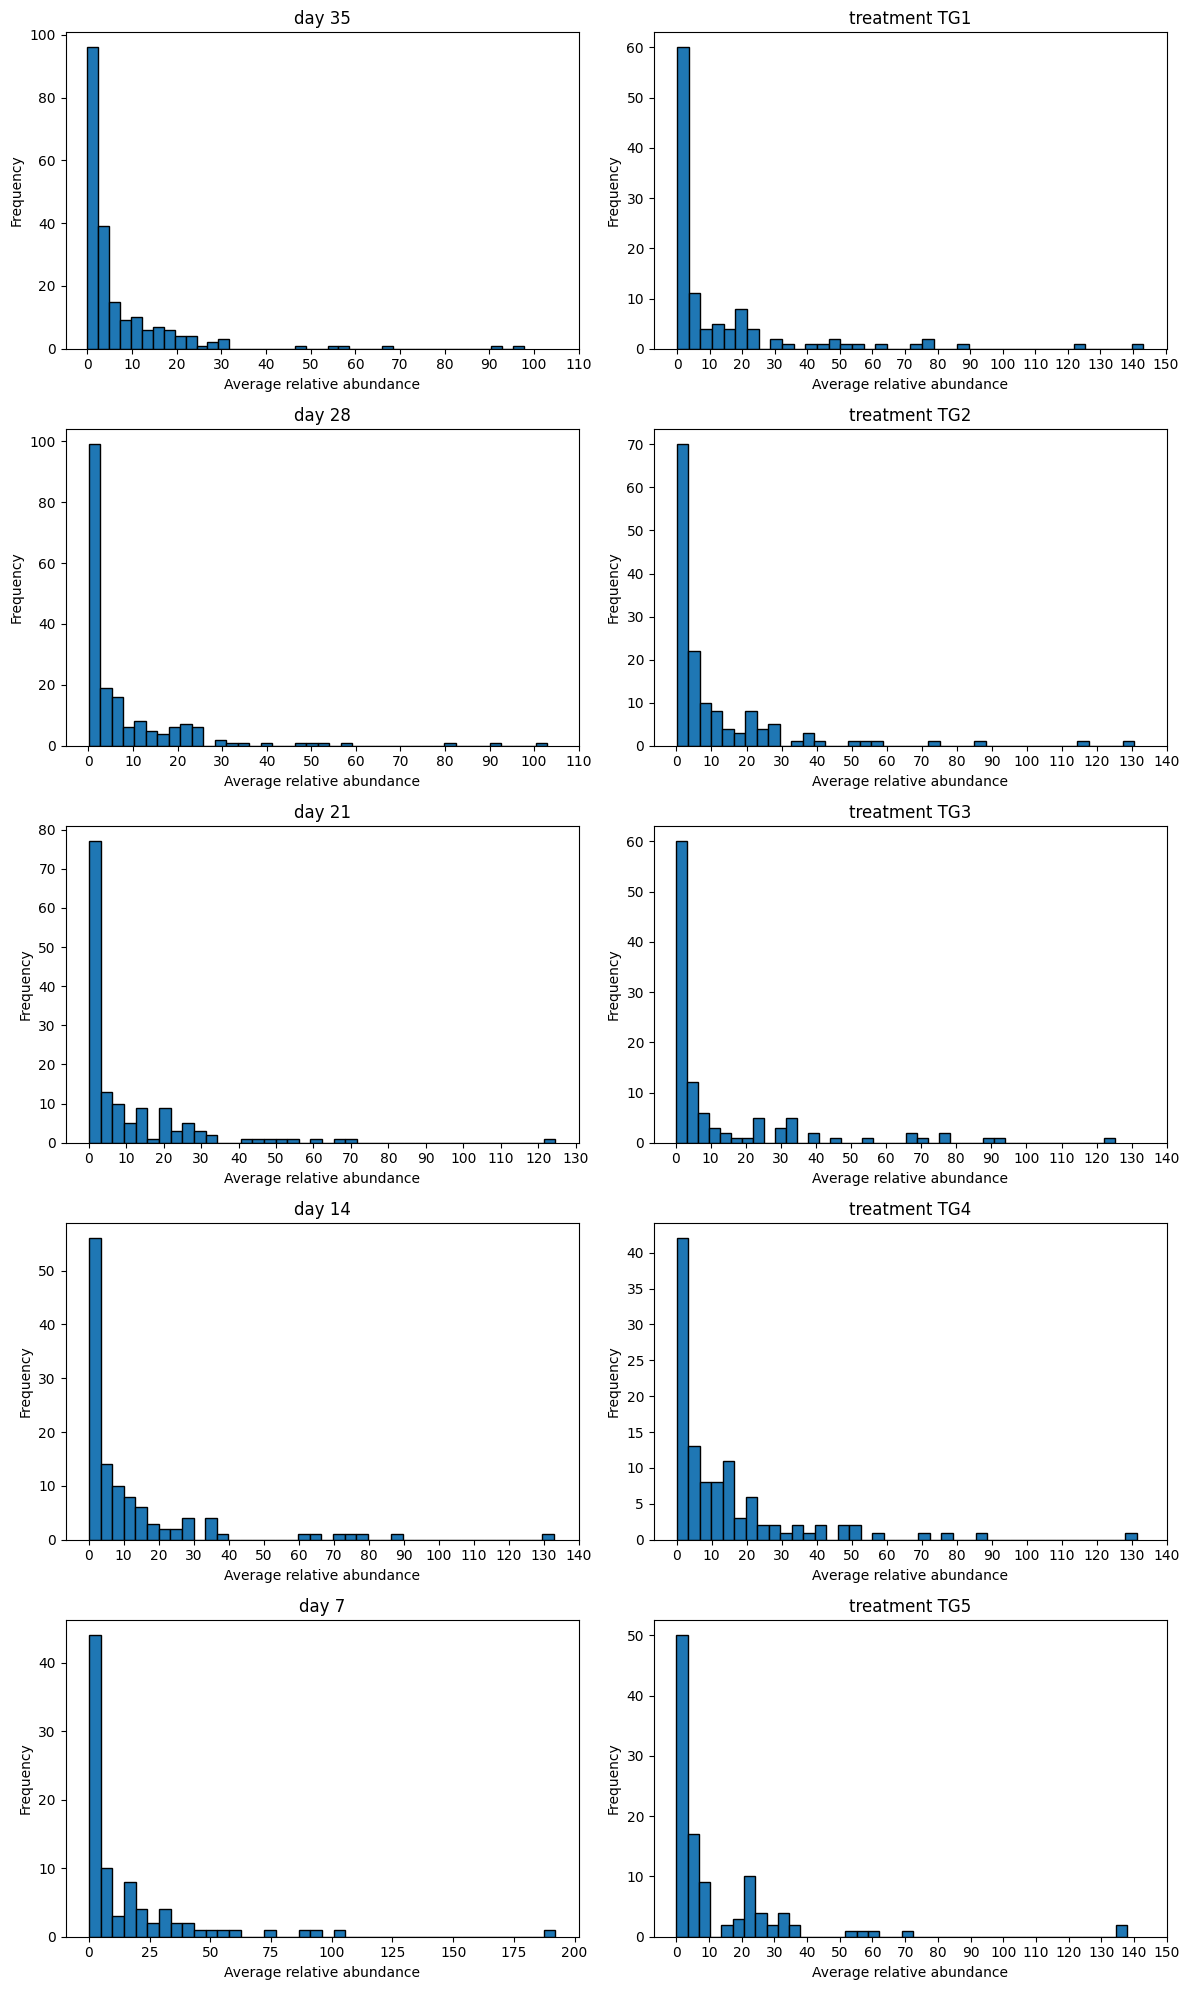

In [116]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 2, figsize=(12, 20))  # 5 rows × 2 columns
axes = axes.T.flatten()   # Flatten to 1D array for easy indexing

plot_idx = 0  # Counter for subplot index

type_case_n_taxa = {}

for type in types:

    type_case_n_taxa[type] = {}

    for case in metadata.loc[type].unique():  # Assuming metadata is a DataFrame with `type` as index

        samples = metadata.columns[metadata.loc[type] == case]
        sub_df = abd[["genome"] + samples.tolist() + ["classification"]]
        abd_data = sub_df.select_dtypes(include=['number'])

        # Identify numeric columns
        numeric_cols = abd_data.columns

        # Keep only rows where there is at least one non-zero value
        df_cleaned = sub_df[(abd_data[numeric_cols] != 0).any(axis=1)].copy()
        df_cleaned["average"] = df_cleaned[numeric_cols].mean(axis=1)

        type_case_n_taxa[type][case] = df_cleaned.select_dtypes("number").shape[0]
        
        if plot_idx >= len(axes):
            print(f"Skipping plot {type}-{case}: too many plots for the 5×2 grid.")
            continue

        # Place subplot on the grid
        ax = axes[plot_idx]

        # Main plot
        ax.hist(df_cleaned["average"], bins=40, edgecolor='black')

        # Define tick step
        tick_step = 10
        xmin, xmax = ax.get_xlim()
        if int(xmax) < 200:
            ax.set_xticks(np.arange(0, int(xmax) + tick_step, tick_step))

        ax.set_xlabel("Average relative abundance")
        ax.set_ylabel("Frequency")
        ax.set_title(f"{type} {case}")

        plot_idx += 1

# Hide unused subplots
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])  # or: axes[j].axis('off')

plt.tight_layout()
plt.show()


In [167]:
from IPython.display import display, Markdown

df_day = pd.DataFrame.from_dict(type_case_n_taxa['day'], orient='index', columns=['Sample count'])
df_treat = pd.DataFrame.from_dict(type_case_n_taxa['treatment'], orient='index', columns=['Sample count'])


day_md = df_day.reset_index().rename(columns={'index': 'Day'}).to_markdown(index=False)
treat_md = df_treat.reset_index().rename(columns={'index': 'Treatment'}).to_markdown(index=False)

display(Markdown(f"### Number of taxa present in the *per day* case\n\n{day_md}"))
display(Markdown(f"### Number of taxa present in the *per treatment* case\n\n{treat_md}"))

### Number of taxa present in the *per day* case

|   Day |   Sample count |
|------:|---------------:|
|    35 |            208 |
|    28 |            188 |
|    21 |            146 |
|    14 |            117 |
|     7 |             88 |

### Number of taxa present in the *per treatment* case

| Treatment   |   Sample count |
|:------------|---------------:|
| TG1         |            112 |
| TG2         |            146 |
| TG3         |            110 |
| TG4         |            110 |
| TG5         |            109 |

You may check for example whether you do have evnn using what we argue we use the following to check the treatment and the day.

In [48]:
metadata[df_cleaned.columns[1:-1]].head(5)

sample,D300470,D300433,D300479,D300436,D300445,D300442,D300507,D300434,D300460,D300513,...,D300524,D300469,D300520,D300505,D300493,D300499,D300503,D300464,D300515,D300497
batch,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,...,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009,S3B009
animal,G002,G004,G005,G006,G007,G108,G110,G111,G112,G113,...,G115,G116,G118,G119,G120,G121,G122,G123,G124,G125
tissue,Digesta,Digesta,Digesta,Digesta,Digesta,Digesta,Digesta,Digesta,Digesta,Digesta,...,Digesta,Digesta,Digesta,Digesta,Digesta,Digesta,Digesta,Digesta,Digesta,Digesta
treatment,TG5,TG5,TG5,TG5,TG5,TG5,TG5,TG5,TG5,TG5,...,TG5,TG5,TG5,TG5,TG5,TG5,TG5,TG5,TG5,TG5
day,14,14,7,14,7,14,21,21,21,21,...,28,28,28,28,28,35,35,35,35,35


,D300470,D300433,D300479,D300436,D300445,D300442,D300507,D300434,D300460,D300513,...,D300524,D300469,D300520,D300505,D300493,D300499,D300503,D300464,D300515,D300497
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,5.068531,6.244748,14.243249,0.000000,0.000000,6.557682,0.000000,3.488264,5.960103,...,7.633386,16.838742,23.439109,10.233177,7.759339,12.926734,5.729738,12.526382,5.296297,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,24.631969,37.762130,34.700243,15.876490,87.343606,19.326630,18.983182,18.651969,18.674942,29.796954,...,13.820177,19.097925,32.406827,8.486407,36.327935,15.803373,23.278688,24.773763,12.790131,7.361412
219,0.000000,1.616095,0.000000,2.304824,4.609564,3.455939,6.117340,2.055229,3.945678,6.632255,...,3.321188,8.572389,19.450774,2.263671,17.486717,16.178517,1.579626,17.645893,4.046051,1.721655
220,0.000000,0.000000,0.000000,1.045968,0.000000,0.000000,17.981237,8.394369,0.000000,1.323815,...,11.098767,0.000000,1.237666,1.091515,3.520348,28.828782,21.528210,7.020633,13.706651,11.851864
221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.551834,6.422410,12.654194,19.409241,9.396394


### Build input files for `microbetag`

Since we are interested in how communities change per treatment and per day, besides the overall network, we will also build `microbetag`-annotated networks per-day and per-treatment. 

To do so, we need to split the above dataframes accordingly, for each such _type_.

In [82]:
for type in types:

    # Get the treatment row as a Series
    cases = metadata.loc[type, :]

    for case in cases.unique():
        
        if type == "treatment":
            for i, c in enumerate(case):
                if c.isdigit():
                    ltype, lcase = case[:i], str(case[i:])
                    break
        else:
            lcase = str(case)
            ltype = type

        # Get column names (samples) matching the current treatment
        selected_samples = cases[cases == case].index

        # Subset the metadata to only those samples (i.e., columns)
        tr_metadata = metadata[selected_samples]
        
        # Get same samples from the abundance table
        tr_abd = abd[ ["genome"] + tr_metadata.columns.tolist() + ["classification"]]

        # Export those subset of the dataframes to files
        abd_outfile  = "_".join(["abd", ltype, lcase])
        abd_outfile += ".tsv"
        meta_outfile = "_".join(["metadata", ltype, lcase])
        meta_outfile += ".tsv"

        tr_abd.to_csv(microbetag_data / "_".join(["per", type]) / abd_outfile, index=False)
        tr_metadata.to_csv(microbetag_data / "_".join(["per", type]) / meta_outfile, index_label="sample", sep="\t")

Cool! 

Now, we are ready to fire `microbetag` !

We will use _microbetag_  `v1.0.4`. To run `microbetag` we need to fill-in a configuration file, which we need to make sure it is the one that corresponds to the _microbetag_ version we'using.

In [83]:
import yaml 

for type in types:

    input_dir = microbetag_data / "_".join(["per", type])

    # Find all abd_day_*.tsv files
    abd_files = sorted(input_dir.glob("abd_*.tsv"))

    for abd_file in abd_files:

        # Extract the day number (e.g., 14 from abd_day_14.tsv); .stem is an attribute of a Path object that returns the filename without its suffix (extension).
        case = abd_file.stem.split('_')[-1]

        if type == "treatment":
            ltype = "TG"
            lcase = case.split("TG")[-1]
        else:
            ltype = type
            lcase = str(case)

        # Construct the corresponding metadata filename
        metadata_file = input_dir / f"metadata_{ltype}_{lcase}.tsv"

        if metadata_file.exists():

            # Open and read the YAML file
            with open(microbetag_data / template_config, 'r') as f:
                config = yaml.safe_load(f)

            config["abundance_table_file"]["file_path"] = str(abd_file)
            config["metadata_file"]["file_path"]        = str(metadata_file)
            
            # In case of day 7 we need to edit FlashWeave's arguments because of low number of samples
            if ltype == "day" and lcase == 7: 
                config["max_k"]["value"] = 2
                config["n_obs_min"]["value"] = 15

        else:
            print(f"Warning: Metadata file for {ltype} {lcase} not found!")

        # Export to YAML file
        conf_file = "_".join(["config", ltype, lcase])
        conf_file += '.yaml'
        with open(conf_file, 'w') as f:
            yaml.dump(config, f, sort_keys=False)

In [ ]:
# Build tarball
tar -czf reconstructions/GENREs.tar.gz reconstructions/GENREs/
tar -czf pathway_complementarity.tar.gz pathway_complementarity/

#Decompress tarball 
tar -zxvf reconstructions/GENREs.tar.gz
tar -zxvf pathway_complementarity.tar.gz


We now call `microbetag` for each configure file built. 
We have built a bash script for this (`run_mtg.sh`) to avoid notebook-related issues.

> Attention !
>
> GitHub has a max size for a single file at 100MB. Thus the precalculations in some cases are stored as tarballs.
> In case you run this notebook for the first time, make sure you decompress those under the `mgg_prec` output folder.

From a terminal, **activate** the _microbetag_ `conda` environment, and make sure `microbetag` is there: 

In [ ]:
!microbetag -h

Then fire ```bash run_mtg.sh``` - make sure you do so from:

In [ ]:
root 

The `microbetag`-annotated networks will be stored under `microbetag_nets/`

## Functions

Load dependencies

In [ ]:
# General
import os

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import plotly.io as pio
import plotly.express as px
import webbrowser

# Utils
from utils import *

In [ ]:
# Load the datasets
genome_taxonomy = pd.read_csv("../data/gtdbtk.summary.tsv", sep="\t")
genome_quality = pd.read_csv("../data/genomeInfo.csv")

selected_genomes = pd.read_csv("../data/Wdb.csv")
selected_genomes["genome"] = selected_genomes["genome"].str.replace(".fa", "", regex=True)
selected_genomes = selected_genomes["genome"]

# Modify genome names
genome_taxonomy['genome'] = genome_taxonomy['user_genome'].str.replace('.fa', '', regex=True)

genome_taxonomy = genome_taxonomy[genome_taxonomy['genome'].isin(selected_genomes)]

# Split the classification into separate columns
genome_taxonomy[['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']] = genome_taxonomy['classification'].str.split(';', expand=True)

# Select the relevant columns
genome_taxonomy = genome_taxonomy[['genome', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']]

# Process genome quality data
genome_quality['genome'] = genome_quality['genome'].str.replace('.fa', '', regex=True)

# Filter only selected genomes (the 223 species-representatives)
genome_quality = genome_quality[genome_quality['genome'].isin(selected_genomes)]

# Select relevant columns
genome_quality = genome_quality[['genome', 'completeness', 'contamination', 'length']]

# Merge the two dataframes on the 'genome' column
genome_metadata = pd.merge(genome_taxonomy, genome_quality, on='genome', how='left')

In [ ]:
genome_taxonomy.head()
genome_quality.head()
genome_metadata.head()

Functions for the needs of the stats.

## Discussing the nets

### Overall network

***Salmonella*** is _positively_ associated with **lactic acid**; in agreement with _in vitro_ data. 

It is also _positively_ associated with _Agathobaculum stercoravium_ (family: Butyricicoccaceae). 

I found interesting the subnetworks for TG1 and TG5 where we had a _triange_ of two species having a positive association with the treatment, and a negative association between them! 


### Day

### TG1

### TG1

### TG1

### TG1

### TG1

### TG1

## Stats

### Prep

Keep track of the non-sequence nodes.

In [ ]:
env_var = ["treatment_TG1", "treatment_TG2", "treatment_TG3", "treatment_TG4", "treatment_TG5", 
           "day", "salmonella", "synbiotic_water", "synbiotic_feed"
]
metabolites = [
"L-Tyrosine", "L-Phenylalanine", "L-Tryptophan", "L-Aspartic Acid", "L-Arginine", "L-Leucine", "L-Glutamic acid", "L-Glutamine", 
"L-Histidine", "L-Lysine", "L-Methionine", "L-Proline", "L-Threonine", "Thiamine", "Adenine", 'Guanosine', "L-Valine" , "L-Alanine", 
"L-Asparagine", "L-Isoleucine", "L-Serine", "Lactic acid", "Sulfoacetic acid"
]
env_set = set(env_var)
metabolites_set = set(metabolites)

In [ ]:
root_dir = os.getcwd()
cx_dir = os.path.join(root_dir, "microbetag_nets")

In [ ]:
cx_overall_filepath = os.path.join(cx_dir, "overall.cx2")
cx_overall = load_cx2(cx_overall_filepath)
overall_mtg = MggParser(cx_overall, env_set, metabolites_set),

### Per day networks

#### Prep

Calculate statistics on the microbetag-annotated networks per day.

Load the `.cx2` files 

In [ ]:
cx_07_filepath = os.path.join(cx_dir, "microbetag_net_day_7.cx2")  ; cx_07 = load_cx2(cx_07_filepath)
cx_14_filepath = os.path.join(cx_dir, "microbetag_net_day_14.cx2") ; cx_14 = load_cx2(cx_14_filepath)
cx_21_filepath = os.path.join(cx_dir, "microbetag_net_day_21.cx2") ; cx_21 = load_cx2(cx_21_filepath)
cx_28_filepath = os.path.join(cx_dir, "microbetag_net_day_28.cx2") ; cx_28 = load_cx2(cx_28_filepath)
cx_35_filepath = os.path.join(cx_dir, "microbetag_net_day_35.cx2") ; cx_35 = load_cx2(cx_35_filepath)

Example of how an edge looks like on the `.cx2` format.
```json

// Edge example
    {'id': 245,
    's': 83,
    't': 2,
    'v': {'interaction type': 'cooccurrence',
    'microbetag::weight': 0.9523214101791382,
    'shared name': 'L-Leucine (cooccurss with) L-Isoleucine'}}

```

In [ ]:
days = [7, 14, 21, 28, 35]

#### Count the number of **taxon-metabolite associations** in the day-specific networks and correlate it with day

In [ ]:
days_parsed_nets = {
    "day07" : MggParser(cx_07, env_set, metabolites_set),
    "day14" : MggParser(cx_14, env_set, metabolites_set),
    "day21" : MggParser(cx_21, env_set, metabolites_set),
    "day28" : MggParser(cx_28, env_set, metabolites_set),
    "day35" : MggParser(cx_35, env_set, metabolites_set)
}

In [ ]:
taxon_to_metabo_hits = [
    net.edge_types["taxon_to_metabo"]["counts"] for _, net in days_parsed_nets.items()
]
taxon_to_metabo_hits

In [ ]:
# What to plot
plt.plot(days, taxon_to_metabo_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a metabolite in day-oriented networks")
# Show time
plt.show()


#### Count the number of taxon-treatment associations in the day-specific networks

In [ ]:
taxon_to_env_hits = [
    net.edge_types["taxon_to_env"]["counts"] for _, net in days_parsed_nets.items()
]

In [ ]:
# What to plot
plt.plot(days, taxon_to_env_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a treatment variable in day-oriented networks")
# Show time
plt.show()

#### Correlate time vs total number of cross-feedings across day-specific networks

In [ ]:
overall_number_of_seed_compl = [
    sum(net.num_total_compls.values()) for _, net in days_parsed_nets.items()
]

In [ ]:
# What to plot
plt.plot(days, overall_number_of_seed_compl, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of complements")
plt.title("Number of seed complements across day-specific networks")
# Show time
plt.show()

#### Correlation between number of positive taxon-to-taxon edged and predicted cross-feedings in day-specific networks 

In [ ]:
number_of_seed_compl_per_day_in_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[0] 
    for _, net in days_parsed_nets.items()
]

In [ ]:
# What to plot
plt.plot(days, number_of_seed_compl_per_day_in_positive_associated_taxa, marker='o', linestyle='-')
# Labels and title
plt.xlabel("day")
plt.ylabel("number of complements")
plt.title("Number of seed complements between co-occurrying taxa - positive")
# Show time
plt.show()

In [ ]:
mean_of_seed_compl_in_positive_associated_taxa = [
    number_of_seed_compl_per_day_in_positive_associated_taxa[index] / len(net.pos_pairs_node_ids) for index, net in enumerate(days_parsed_nets.values())
]
mean_overall_number_of_seed_compl = [
    overall_number_of_seed_compl[index] /  len(net.num_total_compls)  for index, net in enumerate(days_parsed_nets.values())
]

In [ ]:
# What to plot
plt.plot(days, mean_of_seed_compl_in_positive_associated_taxa, marker='o', linestyle='-', label="between co-occurrying taxa")
plt.plot(days, mean_overall_number_of_seed_compl, marker="*", linestyle="dotted", color="grey", label="overall taxon-to-taxon")
# Labels and title
plt.xlabel("day")
plt.ylabel("mean of number of complements")
plt.title("Mean number of seed complements between co-occurrying taxa acrross day-oriented networks")
# Show time
plt.show()

#### Unique compounds involved in potential cross-feedings

In [ ]:
unique_compounds_in_cf_of_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[1]
    for _, net in days_parsed_nets.items()
]

In [ ]:
lengths = [
    len(x) for x in unique_compounds_in_cf_of_positive_associated_taxa
]

In [ ]:
plt.plot(days, lengths, marker='o', linestyle='-')

# Labels and title
plt.xlabel("day")
plt.ylabel("number of unique compounds ")
plt.title("Number of unique compound involved in potential cross-feeding in positive")

# Show the plot
plt.show()

In [ ]:
day_set = { "day_" + str(i): j for i,j in zip(days, unique_compounds_in_cf_of_positive_associated_taxa)}

In [ ]:
venn(day_set)
plt.title("Overlap of the compounds involved in the potential cross-feeding interactions across the per-day networks")

# Show the plot
plt.show()

In [ ]:
day7 = days_parsed_nets["day07"]


```python
# node ids 15-112 both in cooccurence and complets/copmetes
day7.cx2.get_edges()
```

In [ ]:
dfs = {}

ratio_ggplots = []

for _, day in enumerate(days_parsed_nets):                      # # NOTE (Haris Zafeiropoulos, 2025-04-02):  Enumerate will keep the same order as long as we do not edit the days_parased_nets dictionary

    day_net = days_parsed_nets[day]

    df = process_cooccurrence_and_regression(
        day_net, day, metabolites, env_set
    )

    dfs[day] = df


for day, df in dfs.items():

        ratio_ggplots.append( plot_neighbors_per_seed_compl(df, day,  model="WLS") )  # or OLS

In [ ]:
dfs["day35"]

In [ ]:
for day, df in dfs.items():

    r2, p_v = weighted_pearson_with_pvalue(df, "neighbors_num", "compl_ratio", "compl_ratio")
    
    print(day, r2, p_v)
    
    
    spearman = spearman_corr(df, "neighbors_num", "compl_ratio")
    
    print(day, spearman)


In the `ratio_ggplots`, we now have for each day net its corresponding plot:

In [ ]:
ratio_ggplots[0][0]

but also, its data frame.

In [ ]:
ratio_ggplots[0][1]

To save all the per day plots with the seed complementarities number against the number of positive neighbors:

In [ ]:
for index, plot in enumerate(ratio_ggplots):
    
    ggsave(plot[0], filename=f"figs/seed_stats/compls_per_neighbor_wls_{days[index]}.svg", width=8, height=8, format="svg", dpi=300)

In [ ]:
df = process_cooccurrence_and_regression(
        overall_mtg[0], "overall", metabolites, env_set
    )
df

In [ ]:
overall = plot_neighbors_per_seed_compl(df, "overall")

In [ ]:
ggsave(overall[0], filename="figs/seed_stats/compls_per_neighbor_wls_overall.svg", width=8, height=8, format="svg", dpi=300)

Use the genome metadata `df` we built in the beginning of the notebook, to get the genome size of each MAG.

In [ ]:
for df in dfs.values():
    df["genome size"] = df["name"].map(genome_metadata.set_index("genome")["length"])
    df.rename(columns={"neighbors_num": "number of neighbors", "compl_ratio": "seed complements per neighbor"}, inplace=True)
df.head()

In [ ]:
# Create 3D scatter plot
fig = px.scatter_3d(
    df, 
    x='number of neighbors', 
    y='seed complements per neighbor', 
    z='genome size', 
    color='order',  
    symbol='order',  
    size_max=10,
    opacity=0.8
)

In [ ]:
# Save the plot as an HTML file
html_file = "plotly_3d_plot2.html"
fig.write_html(html_file)

# Open the HTML file in the default web browser
webbrowser.open(html_file)

After I open the `.html` file on my browser, I turned it around a bit and I extracted its ***camera settings*** by moving to the *Inspect* and running the following command on the `Console`:


    JSON.stringify(document.querySelector("div.js-plotly-plot")._fullLayout.scene.camera)


In [ ]:
camera_settings = {
    "up":{"x":0,"y":0,"z":1},
    "center":{"x":0,"y":0,"z":0},
    "eye":{"x":-1.0142173958395229,"y":1.6792529527047904,"z":0.9159544720174357},
    "projection":{"type":"perspective"}
}


In [ ]:
fig.update_layout(
    scene_camera=camera_settings,
    width=1200,  # Width of the figure in pixels
    height=1000,  # Height of the figure in pixels
    plot_bgcolor='rgba(0, 0, 0, 0)',  # Transparent background for the plot area
    paper_bgcolor='rgba(0, 0, 0, 0)',  # Transparent background for the surrounding area
    font=dict(size=14),  # Increase font size for axes and other text elements
    title_font = {"size": 40},
    yaxis_title_font=dict(size=20)   # Increase font size for y-axis label
)

fig.update_xaxes(title='New x label')


# Save the figure as an SVG file
pio.write_image(fig, "plot.svg")

In [ ]:
# cx_07
# days_parsed_nets["day07"].edge_types.keys()

taxa_pair_2_edge_id = {}
for edge_id in cx_07.get_edges():
    edge = cx_07.get_edge(edge_id)    
    pair = (edge["s"], edge["t"])
    if edge["v"]["interaction type"] != "completes/competes with":    
        taxa_pair_2_edge_id[pair] = edge_id


pos_weight_scores, neg_weight_scores = {}, {}
for edge_id in days_parsed_nets["day07"].edge_types["taxon_to_taxon"]["edges"]:
    edge = cx_07.get_edge(edge_id)
    if edge["v"]["interaction type"] in ["cooccurrence", "depletion"]:
        continue

    comp, coop, s, t = edge["v"]["seed::competition"], edge["v"]["seed::cooperation"], edge["s"], edge["t"]
    eid = taxa_pair_2_edge_id.get((s, t), taxa_pair_2_edge_id.get((t, s)))

    flashweave_score = cx_07.get_edge(eid)["v"]["microbetag::weight"]
    target = pos_weight_scores if flashweave_score > 0 else neg_weight_scores
    target[edge_id] = {"cooperation": coop, "competition": comp}
    
    if flashweave_score > 0:
        target[edge_id]["cooccurrence"] = flashweave_score
    else:
        target[edge_id]["depletion"] = flashweave_score


In [ ]:
df = pd.DataFrame.from_dict(pos_weight_scores, orient="index")
df.head()

In [ ]:
from scipy.stats import pearsonr, spearmanr
df = df.astype(float) 
pearson_corr, _ = pearsonr(df["cooperation"], df["cooccurrence"])
print("Pearson correlation:", pearson_corr)

# Spearman correlation (if the relationship is non-linear)
spearman_corr, _ = spearmanr(df["cooperation"], df["cooccurrence"])
print("Spearman correlation:", spearman_corr)

In [ ]:
from scipy.stats import pearsonr, spearmanr
df = df.astype(float) 
pearson_corr, _ = pearsonr(df["competition"], df["cooccurrence"])
print("Pearson correlation:", pearson_corr)

# Spearman correlation (if the relationship is non-linear)
spearman_corr, _ = spearmanr(df["competition"], df["cooccurrence"])
print("Spearman correlation:", spearman_corr)

In [ ]:
sns.regplot(x=df["cooperation"], y=df["cooccurrence"], scatter_kws={"alpha": 0.7}, line_kws={"color": "red"})
plt.title("Regression Plot: Cooperation vs. Cooccurrence")
plt.show()

In [ ]:
from scipy.stats import pearsonr, spearmanr
df = pd.DataFrame.from_dict(neg_weight_scores, orient="index")
df = df.astype(float) 
df.head()

pearson_corr, _ = pearsonr(df["cooperation"], df["depletion"])
print("Pearson correlation:", pearson_corr)

# Spearman correlation (if the relationship is non-linear)
spearman_corr, _ = spearmanr(df["cooperation"], df["depletion"])
print("Spearman correlation:", spearman_corr)

In [ ]:
sns.regplot(x=df["cooperation"], y=df["depletion"], scatter_kws={"alpha": 0.7}, line_kws={"color": "red"})
plt.title("Regression Plot: Cooperation vs. Cooccurrence")
plt.show()

In [ ]:
sns.regplot(x=df["competition"], y=df["depletion"], scatter_kws={"alpha": 0.7}, line_kws={"color": "red"})
plt.title("Regression Plot: Cooperation vs. Cooccurrence")
plt.show()

In [ ]:
day_cx_objects = {
    "day07": cx_07,
    "day14": cx_14,
    "day21": cx_21,
    "day28": cx_28,
    "day35": cx_35
}

all_scores = {
    day: compute_weight_scores(cx_net, days_parsed_nets[day])
    for day, cx_net in day_cx_objects.items()  # Assuming `cx_objects` stores CX networks for each day
}

In [ ]:
import scipy.stats as stats

def plot_regression(ax, df, x_col, y_col, title):
    """Plots a regression plot on the given Axes object and includes p-value and R-squared."""
    # Perform linear regression to get p-value and R-squared
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[x_col], df[y_col])
    r_squared = r_value**2
    
    # Create the regression plot
    sns.regplot(x=df[x_col], y=df[y_col], scatter_kws={"alpha": 0.7}, line_kws={"color": "red"}, ax=ax)
    
    # Add p-value and R-squared to the title
    ax.set_title(f"{title}\n$R^2$ = {r_squared:.2f}, p-value = {p_value:.4f}")

# def plot_regression(ax, df, x1_col, x2_col, y_col, title, color1="red", color2="blue"):
#     """Plots two regression plots on the same Axes object and includes p-value & R-squared."""
    
#     # First regression (x1_col vs y_col)
#     slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(df[x1_col], df[y_col])
#     r_squared1 = r_value1**2
#     sns.regplot(x=df[x1_col], y=df[y_col], scatter_kws={"alpha": 0.7}, line_kws={"color": color1}, ax=ax, label=f"{x1_col} (R²={r_squared1:.2f}, p={p_value1:.4f})")
    
#     # Second regression (x2_col vs y_col)
#     slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(df[x2_col], df[y_col])
#     r_squared2 = r_value2**2
#     sns.regplot(x=df[x2_col], y=df[y_col], scatter_kws={"alpha": 0.7}, line_kws={"color": color2}, ax=ax, label=f"{x2_col} (R²={r_squared2:.2f}, p={p_value2:.4f})")
    
#     # Titles and legend
#     ax.set_title(title)
#     ax.legend()


def plot_dual_regression(ax, df, x_col, y1_col, y2_col, title, color1="blue", color2="red"):
    """Plots two regressions with separate y-axes: one for y1_col (left) and y2_col (right)."""
    
    # Left Y-axis (cooperation vs cooccurrence)
    ax1 = ax
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(df[x_col], df[y1_col])
    r_squared1 = r_value1**2
    sns.regplot(x=df[x_col], y=df[y1_col], scatter_kws={"alpha": 0.7}, line_kws={"color": color1}, ax=ax1)
    ax1.set_ylabel(y1_col, color=color1)
    ax1.tick_params(axis="y", colors=color1)
    
    # Right Y-axis (competition vs cooccurrence)
    ax2 = ax1.twinx()
    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(df[x_col], df[y2_col])
    r_squared2 = r_value2**2
    sns.regplot(x=df[x_col], y=df[y2_col], scatter_kws={"alpha": 0.3, "color": "red"}, line_kws={"color": color2}, ax=ax2)
    ax2.set_ylabel(y2_col, color=color2)
    ax2.tick_params(axis="y", colors=color2)

    # Titles
    ax1.set_xlabel(x_col)
    ax1.set_title(f"{title}\n{y1_col}: R²={r_squared1:.2f}, p={p_value1:.4f} | {y2_col}: R²={r_squared2:.2f}, p={p_value2:.4f}")




In [ ]:
# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (day, scores) in enumerate(all_scores.items()):
    if i >= 6:  # Limit to 6 plots (3×2 grid)
        break

    # Handle positive weight scores
    pos_scores = scores["pos"]
    pos_df = pd.DataFrame.from_dict(pos_scores, orient="index")
    pos_df = pos_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    
    if not pos_df.empty:  # Plot positive weight scores
        plot_regression(axes[i], pos_df, "competition", "cooccurrence", f"{day} (Pos Scores)")
        # plot_regression(axes[i], pos_df, "cooperation", "cooccurrence", f"{day} (Pos Scores)")
        # plot_dual_regression(axes[i], pos_df, "cooccurrence", "cooperation", "competition", f"{day} (Pos Scores)")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [ ]:
# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (day, scores) in enumerate(all_scores.items()):
 
    # Handle negative weight scores (next available subplot)
    neg_scores = scores["neg"]
    neg_df = pd.DataFrame.from_dict(neg_scores, orient="index")
    neg_df = neg_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    
    if not neg_df.empty:  # Plot negative weight scores in the next available subplot
        if i + 1 < 6:  # Ensure we don't exceed the grid
            # plot_regression(axes[i + 1], neg_df, "competition", "depletion", f"{day} (Neg Scores)")
            # plot_regression(axes[i + 1], neg_df, "cooperation", "depletion", f"{day} (Neg Scores)")
            plot_dual_regression(axes[i], neg_df, "depletion", "cooperation", "competition", f"{day} (Neg Scores)")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Per treatment

#### Prep

In [ ]:
cx_tg1_filepath = os.path.join(cx_dir, "microbetag_net_TG1.cx2") ; cx_tg_1 = load_cx2(cx_tg1_filepath)
cx_tg2_filepath = os.path.join(cx_dir, "microbetag_net_TG2.cx2") ; cx_tg_2 = load_cx2(cx_tg2_filepath)
cx_tg3_filepath = os.path.join(cx_dir, "microbetag_net_TG3.cx2") ; cx_tg_3 = load_cx2(cx_tg3_filepath)
cx_tg4_filepath = os.path.join(cx_dir, "microbetag_net_TG4.cx2") ; cx_tg_4 = load_cx2(cx_tg4_filepath)
cx_tg5_filepath = os.path.join(cx_dir, "microbetag_net_TG5.cx2") ; cx_tg_5 = load_cx2(cx_tg5_filepath)

In [ ]:
treatment_parsed_nets = {
    "TG1" : MggParser(cx_tg_1, env_set, metabolites_set),
    "TG2" : MggParser(cx_tg_2, env_set, metabolites_set),
    "TG3" : MggParser(cx_tg_3, env_set, metabolites_set),
    "TG4" : MggParser(cx_tg_4, env_set, metabolites_set),
    "TG5" : MggParser(cx_tg_5, env_set, metabolites_set)
}

In [ ]:
treatment_cx_objects = {
    "TG1": cx_tg_1,
    "TG2": cx_tg_2,
    "TG3": cx_tg_3,
    "TG4": cx_tg_4,
    "TG5": cx_tg_5
}

In [ ]:
all_scores_treatments = {
    treatment: compute_weight_scores(cx_net, treatment_parsed_nets[treatment])
    for treatment, cx_net in treatment_cx_objects.items()  # Assuming `cx_objects` stores CX networks for each day
}

In [ ]:
# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (day, scores) in enumerate(all_scores_treatments.items()):
    if i >= 6:  # Limit to 6 plots (3×2 grid)
        break

    # Handle negative weight scores (next available subplot)
    neg_scores = scores["neg"]
    neg_df = pd.DataFrame.from_dict(neg_scores, orient="index")
    neg_df = neg_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    
    if not neg_df.empty:  # Plot negative weight scores in the next available subplot
        if i + 1 < 6:  # Ensure we don't exceed the grid
            # plot_regression(axes[i + 1], neg_df, "competition", "depletion", f"{day} (Neg Scores)")
            plot_dual_regression(axes[i], neg_df, "depletion", "cooperation", "competition", f"{day} (Neg Scores)")

            

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [ ]:
# Define figure with 3 rows × 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  
axes = axes.flatten()  # Flatten to 1D for easy indexing

# Loop over networks & plot
for i, (day, scores) in enumerate(all_scores_treatments.items()):
    if i >= 6:  # Limit to 6 plots (3×2 grid)
        break
    # Handle positive weight scores
    pos_scores = scores["pos"]
    pos_df = pd.DataFrame.from_dict(pos_scores, orient="index")
    pos_df = pos_df.apply(pd.to_numeric, errors="coerce").dropna()  # Ensure numeric values and drop NaN rows
    if not pos_df.empty:  # Plot positive weight scores
        # plot_regression(axes[i], pos_df, "cooperation", "cooccurrence", f"{day} (Pos Scores)")
        plot_dual_regression(axes[i], pos_df, "cooccurrence", "cooperation", "competition", f"{day} (Pos Scores)")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [ ]:
pos_df

In [ ]:
tg_microbetag_nets = [cx_tg_1, cx_tg_2, cx_tg_3, cx_tg_4, cx_tg_5]
treatments = ["TG1", "TG2", "TG3", "TG4", "TG5"]
treatments_descr = [
    "TG1:Salmonella, synbiont both water and feed",
    "TG2:Salmonella, synbiont in water",
    "TG3:Salmonella, synbiont in feed",
    "TG4:Salmonella, no symbiont",
    "TG5:No Salmonella, no symbiont"
]

In [ ]:
parsed_tg_edges = []
for tg_mgg_net in tg_microbetag_nets:
    num_compl, types, pos_pairs, compounds = parse_microbetag_edges(tg_mgg_net, env_set=env_set, metabolites_set=metabolites_set)
    parsed_tg_edges.append([num_compl, types, pos_pairs, compounds])

#### Count the number of **taxon-metabolite associations** in the day-specific networks and correlate it with day

In [ ]:
taxon_to_metabo_hits = [
    net.edge_types["taxon_to_metabo"]["counts"] for _, net in treatment_parsed_nets.items()
]

In [ ]:
plt.plot(treatments, taxon_to_metabo_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and a metabolite in treatment-oriented networks")
# Create proxy artists for legend
legend_handles = [mlines.Line2D([], [], color='black', marker='o', linestyle='None', label=t) for t in treatments_descr]
# Add legend box
plt.legend(handles=legend_handles, title="TG Categories", loc="lower right", frameon=True)
plt.show()


#### Count the number of taxon-treatment associations in the day-specific networks

In [ ]:
taxon_to_env_hits = [
    net.edge_types["taxon_to_env"]["counts"] for _, net in treatment_parsed_nets.items()
]

In [ ]:
plt.plot(treatments, taxon_to_env_hits, marker='o', linestyle='-')
# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of edges")
plt.title("Edges between a taxon and an envirnmental variable in treatment-oriented networks")

plt.show()

#### Correlate time vs total number of cross-feedings across day-specific networks

In [ ]:
overall_number_of_seed_compl = [
    sum(net.num_total_compls.values()) for _, net in treatment_parsed_nets.items()
]

In [ ]:
plt.plot(treatments, overall_number_of_seed_compl, marker='o', linestyle='-')

# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of complements")
plt.title("Number of seed complements across treatment-specific networks")

# Show the plot
plt.show()

#### Correlation between number of positive taxon-to-taxon edged and predicted cross-feedings in day-specific networks 

In [ ]:
number_of_seed_compl_per_day_in_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[0] 
    for _, net in treatment_parsed_nets.items()
]

In [ ]:
plt.plot(treatments, number_of_seed_compl_per_day_in_positive_associated_taxa, marker='o', linestyle='-')

# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of complements")
plt.title("Number of seed complements between co-occurrying taxa - positive")

# Show the plot
plt.show()

In [ ]:
mean_of_seed_compl_in_positive_associated_taxa = [
    number_of_seed_compl_per_day_in_positive_associated_taxa[index] / len(net.pos_pairs_node_ids) for index, net in enumerate(treatment_parsed_nets.values())
]
mean_overall_number_of_seed_compl = [
    overall_number_of_seed_compl[index] /  len(net.num_total_compls)  for index, net in enumerate(treatment_parsed_nets.values())
]

In [ ]:
plt.plot(treatments, mean_of_seed_compl_in_positive_associated_taxa, marker='o', linestyle='-', label="between co-occurrying taxa")
plt.plot(treatments, mean_overall_number_of_seed_compl, marker="*", linestyle="dotted", color="grey", label="overall taxon-to-taxon")

# Labels and title
plt.xlabel("day")
plt.ylabel("mean of number of complements")
plt.title("Mean number of seed complements between co-occurrying taxa acrross treatment-oriented networks")

plt.legend()

# Show the plot
plt.show()

#### Unique compounds involved in potential cross-feedings of co-occurrying taxa

In [ ]:
unique_compounds_in_cf_of_positive_associated_taxa = [
    get_compls_and_compounds_in_positive_associated_taxa(
        net.cx2, 
        net.pos_pairs_node_ids, 
        net.num_total_compls, 
        net.edge_id_to_unique_compounds
        )[1]
    for _, net in treatment_parsed_nets.items()
]

lengths = [
    len(x) for x in unique_compounds_in_cf_of_positive_associated_taxa
]

In [ ]:
plt.plot(treatments, lengths, marker='o', linestyle='-')

# Labels and title
plt.xlabel("treatment")
plt.ylabel("number of unique compounds ")
plt.title("Number of unique compound involved in potential cross-feeding in positive")

# Show the plot
plt.show()

In [ ]:
treatment_set = { i: j for i,j in zip(treatments, unique_compounds_in_cf_of_positive_associated_taxa)}

In [ ]:
venn(treatment_set)
plt.title("Overlap of the compounds involved in the potential cross-feeding interactions across the per-treatment networks")

# Show the plot
plt.show()